In [268]:
import matplotlib
import numpy as np
import pandas as pd

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# https://zhuanlan.zhihu.com/p/56507515
# https://zhuanlan.zhihu.com/p/410655154
# https://zhuanlan.zhihu.com/p/21275919

In [269]:
src_path = 'indexProcessed.csv'
test_size = 0.1               # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                        # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [270]:
df = pd.read_csv(src_path, sep = ",")
# df = df.drop(df.columns[[0]], axis = 1)
del df['Index']
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...
104219,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [271]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

/tmp/ipykernel_236240/2103356123.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,closeusd,month
40920,1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0.0,12.577200,1
40921,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0,12.639900,1
40922,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0,12.742700,1
40923,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0,12.864301,1
40924,1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0.0,12.885400,1
40925,1965-01-13,1281.670044,1281.670044,1281.670044,1281.670044,1281.670044,0.0,12.816700,1
40926,1965-01-14,1289.500000,1289.500000,1289.500000,1289.500000,1289.500000,0.0,12.895000,1
40927,1965-01-18,1271.680054,1271.680054,1271.680054,1271.680054,1271.680054,0.0,12.716801,1
40928,1965-01-19,1270.339966,1270.339966,1270.339966,1270.339966,1270.339966,0.0,12.703400,1
40929,1965-01-20,1268.880005,1268.880005,1268.880005,1268.880005,1268.880005,0.0,12.688800,1


Text(0.5, 0, 'date')

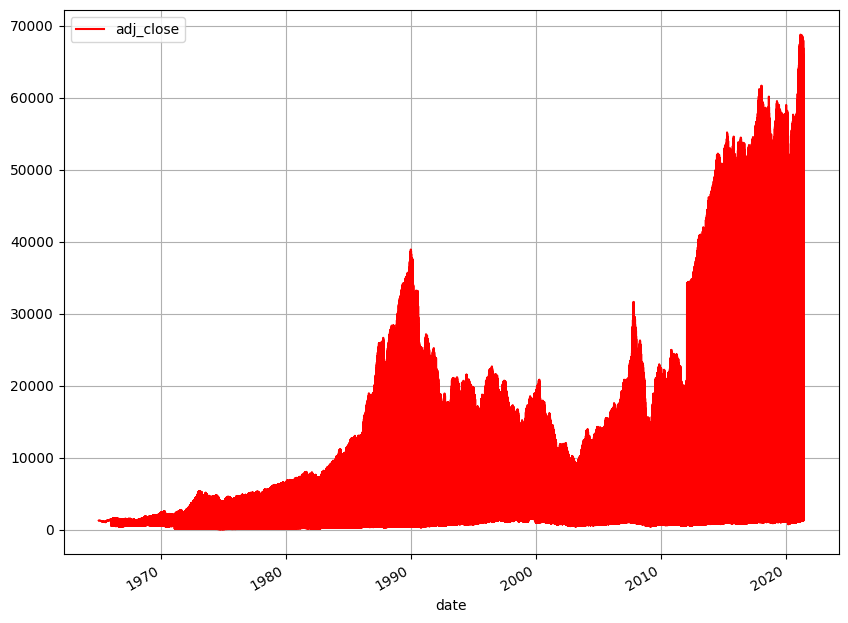

In [272]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x = 'date', y = 'adj_close', style = 'r-', grid = True)
ax.set_xlabel("date")
# df.plot(x = 'date', y = 'adj_close', marker = ',', markevery = 10, color = 'r', ls = '-', lw = 2)

In [273]:
# Get sizes of each of the datasets
num_cv, num_test = int(cv_size*len(df)), int(test_size*len(df))
num_train = len(df) - num_test

print("total_num = " + str(len(df)) )
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train: num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

total_num = 104224
num_train = 93802
num_cv = 20844
num_test = 10422
train.shape = (93802, 9)
cv.shape = (10422, 9)
train_cv.shape = (104224, 9)
test.shape = (0, 9)


Text(0, 0.5, 'USD')

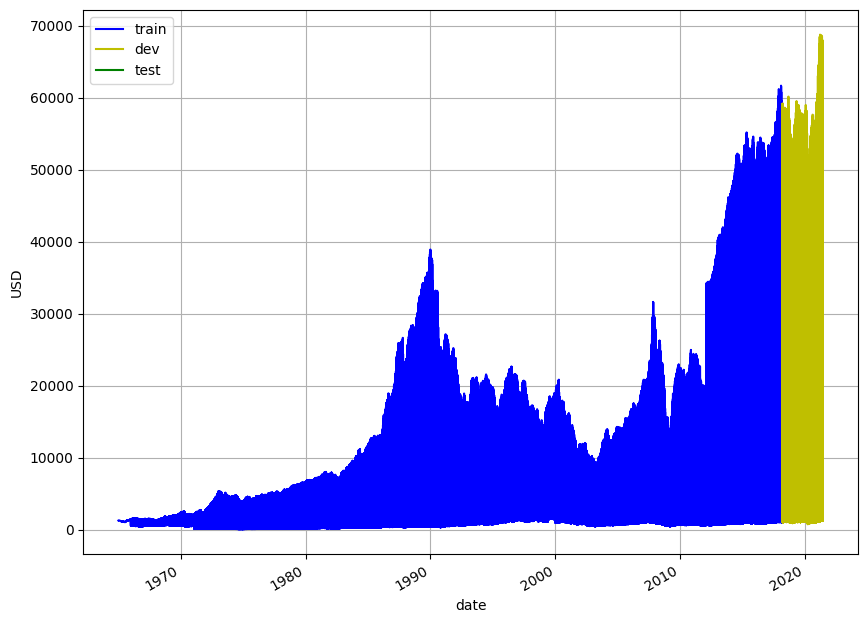

In [274]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x = 'date', y = 'adj_close', style = 'b-', grid = True)
ax = cv.plot(x = 'date', y = 'adj_close', style = 'y-', grid = True, ax = ax)
ax = test.plot(x = 'date', y = 'adj_close', style = 'g-', grid = True, ax = ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [275]:
# X_train,Y_train = df['date'][:num_train], df['adj_close'][:num_train]
# X_test,Y_test = df['date'][num_train:], df['adj_close'][num_train:]
X_train, Y_train = df[:num_train], df[:num_train].adj_close
X_test, Y_test = df[num_train:], df[num_train:].adj_close
# Y_train = df.pop('adj_close')
# X_train = df.pop('date')

X_train = X_train.drop(index = 85883)
Y_train = Y_train.drop(index = 40920)
# X_test = X_test.drop(index = 54793)
# Y_test = Y_test.drop(index = 101091)


date_val = X_test['date']

#del X_train['adj_close']
del X_train['date']
del X_train['closeusd']
#del X_test['adj_close']
del X_test['date']
del X_test['closeusd']

# X_train = X_train['open'].values.reshape(-1, 1)
# X_test = X_test['open'].values.reshape(-1, 1)

# print(Y_train)

mean = Y_train.mean()
print(mean)
Y_train = Y_train.fillna(mean, inplace=False) 

mean = X_train.mean()
X_train = X_train.fillna(mean, inplace=False) 

# mean = X_test.mean()
# X_test = X_test.fillna(mean, inplace=False) 

# mean = Y_test.mean()
# Y_test = Y_test.fillna(mean, inplace=False) 
# # X_train = X_train.values.reshape(-1, 1)

# print(X_train, Y_train)
# print(X_test, Y_test)

7143.061624366659


In [276]:
# from sklearn import linear_model
# reg = linear_model.Ridge(alpha=.5)
# # score = get_score(X_train, y_train)
# reg.fit(X_train, Y_train)
# reg.coef_
# reg.intercept_

from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)
regr.coef_
regr.intercept_

2801.730465331464

In [277]:
# from sklearn.metrics import median_absolute_error

# y_pred = reg.predict(X_train)

# mae = median_absolute_error(Y_train, y_pred)
# string_score = f"MAE on training set: {mae:.2f} $/hour"
# y_pred = reg.predict(X_test)
# mae = median_absolute_error(Y_test, y_pred)
# string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

Y_pred = regr.predict(X_test)
print(Y_pred, len(Y_pred))

from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

[ 9580.27030647  7337.59993528 12166.80039138 ... 20374.2558779
  3576.93052823 20904.12843195] 10422
Coefficients: 
 [-8.42211838e-01 -2.00223560e+00  2.88064815e+00  5.26143650e+01
 -5.20070652e+01 -1.78983196e-08 -3.98755766e+00]
Mean squared error: 40783449.83
Coefficient of determination: 0.78


[ 9580.27030647  7337.59993528 12166.80039138 ... 20374.2558779
  3576.93052823 20904.12843195]
101091    10784.339840
34314      7372.009766
75741     15545.200200
87524     12113.870120
101092    10745.320310
              ...     
66026     15034.780270
66027     14857.910160
54792     28946.140630
60267      1263.619995
54793     29058.109380
Name: adj_close, Length: 10422, dtype: float64


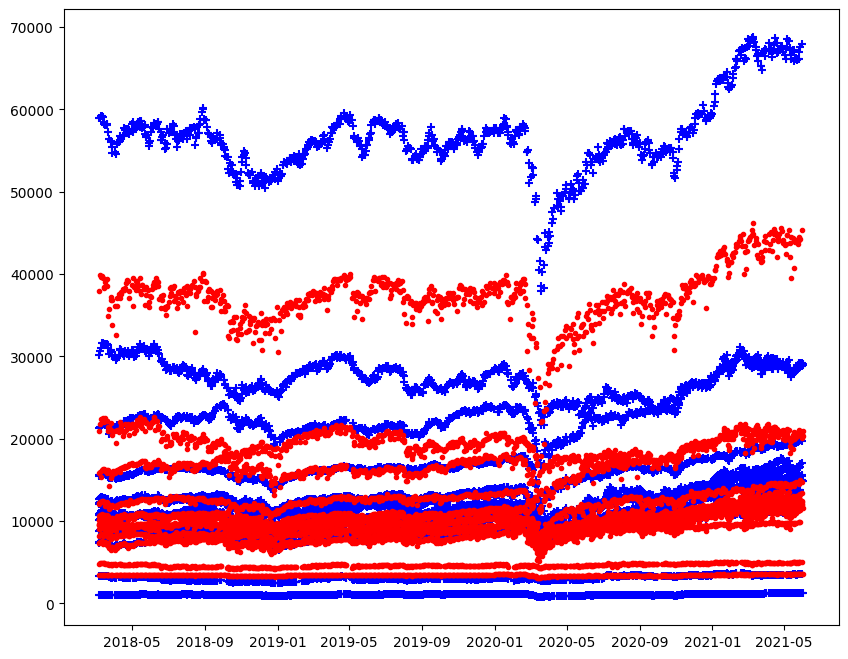

In [278]:
print(Y_pred)
print(Y_test)
ax = plt.scatter(date_val, Y_test, color="blue", marker = '+')
bx = plt.scatter(date_val, Y_pred, color="red", marker = '.')
plt.show()

In [279]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(Y_test, Y_pred))

times = 0
diff = 0
for i in Y_test:
    if int(i) != int(Y_pred[times]):
        # print("different", i, Y_pred[times])
        if (int(i) - int(Y_pred[times]) >= 1):
            diff += 1
            print("different", i, Y_pred[times])
    times += 1
print(diff, "%.2f%%" % (diff / len(Y_pred)))

0.846362435181164
different 10784.33984 9580.270306467844
different 7372.009766 7337.599935278364
different 15545.2002 12166.800391376319
different 12113.87012 10184.056057061602
different 10745.32031 9543.846252863013
different 8784.839844 8233.4353501596
different 30196.91992 20893.996674960315
different 15472.59961 12124.636210015577
different 12707.00977 10633.58252705687
different 58962.64844 37996.11561666203
different 21252.7207 15847.047037065562
different 10904.94727 9459.835187982719
different 10154.2002 9042.7331510124
different 7396.649902 7322.899680126526
different 12245.36035 10115.884220819056
different 10242.65039 9070.426910381715
different 12355.57031 10269.550590987734
different 30654.51953 21808.846844679978
different 15538.7002 12298.596031949573
different 8896.419922 8290.944252757597
different 10823.24023 9625.279695916755
different 12745.00977 10722.491771484443
different 7427.950195 7414.218598646121
different 11019.03711 9615.541590412447
different 21368.0703

In [280]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X_test, Y_test, cv=5)
print(scores)

[1. 1. 1. 1. 1.]


In [281]:
# # print(df['40920'])
# print(type(Y_test), type(X_test))
# #df.drop(df.row[[0]], inplace = True)

# print(Y_test)
# # print(Y_test.drop(52413))
# print(X_test)
# del Y_train[0]

# print("\n", Y_train[40920])
# print("\n", Y_train[40921])
